<a href="https://colab.research.google.com/github/AryanMethil/Diabetes-KNN-vs-Naive-Bayes/blob/main/Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Read the csv file
import pandas as pd
df=pd.read_csv('/content/drive/My Drive/Diabetes/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Print the null values of every column
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
# Print class count to check for imbalance
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [5]:
from sklearn.utils import resample
df_majority = df[df.Outcome==0]
df_minority = df[df.Outcome==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=500,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df = pd.concat([df_majority, df_minority_upsampled])

print(df['Outcome'].value_counts())

1    500
0    500
Name: Outcome, dtype: int64


In [6]:
# Add a "kfolds" column which will indicate the validation set number
df['kfolds']=-1

# Shuffle all the rows and then reset the index
df=df.sample(frac=1,random_state=42).reset_index(drop=True)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,kfolds
0,4,117,62,12,0,29.7,0.380,30,1,-1
1,7,187,68,39,304,37.7,0.254,41,1,-1
2,8,105,100,36,0,43.3,0.239,45,1,-1
3,10,108,66,0,0,32.4,0.272,42,1,-1
4,0,132,78,0,0,32.4,0.393,21,0,-1


In [7]:
from sklearn import model_selection

# Create 5 sets of training,validation sets
strat_kf=model_selection.StratifiedKFold(n_splits=5)

# .split() returns a list of 5 lists (corresponding to the n_splits value)
# Each of these 5 lists consists of 2 lists. 1st one contains training set indices and 2nd one contains validation set indices
# In a dataset of 10 data points, data 1 and 2 will be the validation in 1st fold, data 3 and 4 in the second fold and so on
# 1st iteration of the for loop : trn_ = 3,4,5,6,7,8,9,10 and val_ = 1,2 and fold : 0
# Assign 1st and 2nd row's kfolds value as 0 representing that they will be the validation points for 1st (0th) fold

for fold,(trn_,val_) in enumerate(strat_kf.split(X=df,y=df['Outcome'])):
  df.loc[val_,'kfolds']=fold
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,kfolds
0,4,117,62,12,0,29.7,0.380,30,1,0
1,7,187,68,39,304,37.7,0.254,41,1,0
2,8,105,100,36,0,43.3,0.239,45,1,0
3,10,108,66,0,0,32.4,0.272,42,1,0
4,0,132,78,0,0,32.4,0.393,21,0,0


In [8]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
df_2=pd.DataFrame(scaler.fit_transform(df),index=df.index,columns=df.columns)

# Target column and kfolds column dont need to be scaled
df_2['Outcome']=df['Outcome']
df_2['kfolds']=df['kfolds']
df_2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,kfolds
0,-0.053578,-0.230248,-0.423269,-0.553283,-0.706292,-0.363725,-0.295300,-0.367793,1,0
1,0.787960,2.011697,-0.111124,1.128429,1.840594,0.691889,-0.680386,0.579018,1,0
2,1.068473,-0.614581,1.553653,0.941572,-0.706292,1.430819,-0.726229,0.923314,1,0
3,1.629498,-0.518498,-0.215172,-1.300711,-0.706292,-0.007455,-0.625373,0.665092,1,0
4,-1.175629,0.250169,0.409119,-1.300711,-0.706292,-0.007455,-0.255569,-1.142458,0,0


In [9]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [28]:
def run(fold,df,models,print_details=False):
  
  # Training and validation sets
  df_train=df[df['kfolds']!=fold].reset_index(drop=True)
  df_valid=df[df['kfolds']==fold].reset_index(drop=True)


  # x and y of training dataset
  x_train=df_train.drop('Outcome',axis=1).values
  y_train=df_train.Outcome.values

  # x and y of validation dataset
  x_valid=df_valid.drop('Outcome',axis=1).values
  y_valid=df_valid.Outcome.values

  # accuracy => will store accuracies of the models  (same for confusion_matrices)
  accuracy=[]
  confusion_matrices=[]
  classification_report=[]

  for model_name,model_constructor in list(models.items()):
    clf=model_constructor
    clf.fit(x_train,y_train)

    # preds_train, preds_valid => predictions when training and validation x are fed into the trained model
    preds_train=clf.predict(x_train)
    preds_valid=clf.predict(x_valid)

    acc_train=metrics.accuracy_score(y_train,preds_train)
    acc_valid=metrics.accuracy_score(y_valid,preds_valid)
    conf_matrix=metrics.confusion_matrix(y_valid,preds_valid)
    class_report=metrics.classification_report(y_valid,preds_valid)

    accuracy.append(acc_valid)
    confusion_matrices.append(conf_matrix)
    classification_report.append(class_report)

    if(print_details==True):
      print(f'Model => {model_name} => Fold = {fold} => Training Accuracy = {acc_train} => Validation Accuracy = {acc_valid}')

  if(print_details==True):
    print('\n--------------------------------------------------------------------------------------------\n')
    
  return accuracy,confusion_matrices,classification_report

In [50]:
def feature_selection(fold,df,models,target_name):

  target_index=df.columns.get_loc(target_name)
  kfolds_index=df.columns.get_loc('kfolds')

  good_features=[]
  best_scores=[]

  num_features=df.shape[1]-2

  while True:
    this_feature=None
    best_score=0

    for feature in range(num_features):

      if feature in good_features:
        continue
      
      selected_features=good_features+[feature]

      df_train=df.iloc[:, selected_features + [target_index,kfolds_index]]

      accuracy,confusion_matrices,classification_report=run(fold,df_train,models)

      if(accuracy[0]>best_score):
        this_feature=feature
        best_score=accuracy[0]
      
    if(this_feature!=None):
      good_features.append(this_feature)
      best_scores.append(best_score)
    
    if(len(best_scores)>2):
      if(best_scores[-1]<best_scores[-2]):
        break
    
  return best_scores[:-1] , df.iloc[:, good_features[:-1] + [target_index,kfolds_index]]

      


In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [31]:
# Find the optimal value of the n_neighbors parameter

models={f'KNN_{i}':KNeighborsClassifier(n_neighbors=i) for i in range(2,31)}

In [33]:
# run the model only for fold number 4 ie the 5th fold

accuracy,confusion_matrices,classification_report=run(fold=4,df=df_2,models=models,print_details=True)

Model => KNN_2 => Fold = 4 => Training Accuracy = 0.91375 => Validation Accuracy = 0.635
Model => KNN_3 => Fold = 4 => Training Accuracy = 0.8575 => Validation Accuracy = 0.66
Model => KNN_4 => Fold = 4 => Training Accuracy = 0.8575 => Validation Accuracy = 0.68
Model => KNN_5 => Fold = 4 => Training Accuracy = 0.84125 => Validation Accuracy = 0.665
Model => KNN_6 => Fold = 4 => Training Accuracy = 0.8225 => Validation Accuracy = 0.66
Model => KNN_7 => Fold = 4 => Training Accuracy = 0.815 => Validation Accuracy = 0.675
Model => KNN_8 => Fold = 4 => Training Accuracy = 0.82 => Validation Accuracy = 0.675
Model => KNN_9 => Fold = 4 => Training Accuracy = 0.8125 => Validation Accuracy = 0.7
Model => KNN_10 => Fold = 4 => Training Accuracy = 0.80375 => Validation Accuracy = 0.695
Model => KNN_11 => Fold = 4 => Training Accuracy = 0.795 => Validation Accuracy = 0.71
Model => KNN_12 => Fold = 4 => Training Accuracy = 0.79 => Validation Accuracy = 0.7
Model => KNN_13 => Fold = 4 => Training 

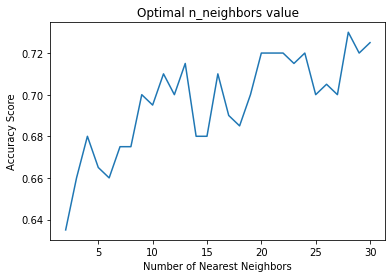

In [34]:
x=[i for i in range(2,31)]
y=accuracy
plt.plot(x,y)
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Accuracy Score')
plt.title("Optimal n_neighbors value")
plt.show()

In [56]:
models={'KNN': KNeighborsClassifier(n_neighbors=28)}

In [57]:
best_scores,df_optimal_KNN=feature_selection(fold=4,df=df_2,models=models,target_name='Outcome')

In [58]:
df_optimal_KNN.head()

,Glucose,Pregnancies,Age,BMI,Outcome,kfolds
0,-0.230248,-0.053578,-0.367793,-0.363725,1,0
1,2.011697,0.787960,0.579018,0.691889,1,0
2,-0.614581,1.068473,0.923314,1.430819,1,0
3,-0.518498,1.629498,0.665092,-0.007455,1,0
4,0.250169,-1.175629,-1.142458,-0.007455,0,0


In [59]:
models={'Naive Bayes' : GaussianNB()}

In [60]:
best_scores,df_optimal_NB=feature_selection(fold=4,df=df_2,models=models,target_name='Outcome')

In [61]:
df_optimal_NB.head()

,Glucose,Pregnancies,BMI,Outcome,kfolds
0,-0.230248,-0.053578,-0.363725,1,0
1,2.011697,0.787960,0.691889,1,0
2,-0.614581,1.068473,1.430819,1,0
3,-0.518498,1.629498,-0.007455,1,0
4,0.250169,-1.175629,-0.007455,0,0


In [62]:
# Compare between KNN and Naive Bayes

models={
        'KNN': KNeighborsClassifier(n_neighbors=28),
        'Gaussian Naive Bayes': GaussianNB(),
        }

In [64]:
# accuracies => list of 5 lists. Each list will contain 3 values ie KNN accuracy, Gaussian Naive Bayes

accuracies,confusion_matrices,classification_reports=[],[],[]
for f in range(5):
  accuracy,confusion_matrix,classification_report=run(f,df_optimal_NB,models=models,print_details=True)
  accuracies.append(accuracy)
  confusion_matrices.append(confusion_matrix)
  classification_reports.append(classification_report)

Model => KNN => Fold = 0 => Training Accuracy = 0.76625 => Validation Accuracy = 0.72
Model => Gaussian Naive Bayes => Fold = 0 => Training Accuracy = 0.74 => Validation Accuracy = 0.715

--------------------------------------------------------------------------------------------

Model => KNN => Fold = 1 => Training Accuracy = 0.77125 => Validation Accuracy = 0.74
Model => Gaussian Naive Bayes => Fold = 1 => Training Accuracy = 0.7325 => Validation Accuracy = 0.75

--------------------------------------------------------------------------------------------

Model => KNN => Fold = 2 => Training Accuracy = 0.77125 => Validation Accuracy = 0.755
Model => Gaussian Naive Bayes => Fold = 2 => Training Accuracy = 0.7275 => Validation Accuracy = 0.76

--------------------------------------------------------------------------------------------

Model => KNN => Fold = 3 => Training Accuracy = 0.7725 => Validation Accuracy = 0.68
Model => Gaussian Naive Bayes => Fold = 3 => Training Accuracy = 0

In [65]:
print(accuracies)

[[0.72, 0.715], [0.74, 0.75], [0.755, 0.76], [0.68, 0.635], [0.72, 0.76]]


In [66]:
x_axis_labels=['Predicted Normal','Predicted Diabetic']
y_axis_labels=['True Normal','True Diabetic']

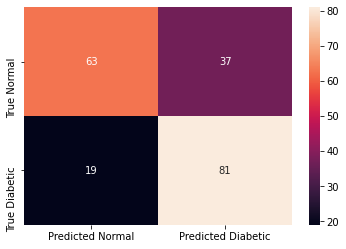

In [67]:
import seaborn as sns

# Heatmap of confusion matrix of 5th fold of KNN

sns.heatmap(confusion_matrices[4][0],xticklabels=x_axis_labels,yticklabels=y_axis_labels,annot=True)


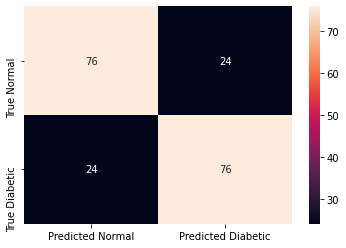

In [68]:
# Heatmap of confusion matrix of 5th fold of Naive Bayes

sns.heatmap(confusion_matrices[4][1],xticklabels=x_axis_labels,yticklabels=y_axis_labels,annot=True)


In [69]:
# Classification report of 5th fold of KNN

print("KNN")
print(classification_reports[4][0])

KNN
              precision    recall  f1-score   support

           0       0.77      0.63      0.69       100
           1       0.69      0.81      0.74       100

    accuracy                           0.72       200
   macro avg       0.73      0.72      0.72       200
weighted avg       0.73      0.72      0.72       200



In [70]:
# Classification report of 5th fold of Naive Bayes

print("Naive Bayes")
print(classification_reports[4][1])

Naive Bayes
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       100
           1       0.76      0.76      0.76       100

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.76      0.76      0.76       200

